In [1]:
import sxobsplan

from pathlib import Path
import pandas as pd
import astropy.units as u
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import _rcparams

In [2]:
pdes = "161P" # Primary designation

In [3]:
# SBDB
fpath_sbdb = Path("../data/sbdb_query_results_comet_ver250926.csv")
df_sbdb = pd.read_csv(fpath_sbdb)
target = df_sbdb[df_sbdb["pdes"] == pdes].iloc[0]
target

spkid                    1000042
full_name      161P/Hartley-IRAS
pdes                        161P
name                Hartley-IRAS
prefix                         P
                    ...         
A2_sigma                     NaN
A3                           NaN
A3_sigma                     NaN
DT                           NaN
DT_sigma                     NaN
Name: 157, Length: 79, dtype: object

In [4]:
# Ephemeris
EPHDIR = Path("../eph")
fpath_eph = EPHDIR / f"{''.join(pdes.split())}.csv"
eph = pd.read_csv(fpath_eph)
eph

,targetname,datetime_str,datetime_jd,M1,M2,k1,k2,phasecoeff,solar_presence,lunar_presence,...,lunar_illum,sunTargetPA,velocityPA,OrbPlaneAng,constellation,GlxLon,GlxLat,alpha_true,PABLon,PABLat
0,161P/Hartley-IRAS,2025-Jan-01 00:00,2460676.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,1.4673,6.171,75.352,8.56637,Dor,279.640365,-28.114342,8.7118,149.9716,-87.1778
1,161P/Hartley-IRAS,2025-Jan-06 00:00,2460681.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,38.8737,13.757,78.227,8.45089,Dor,279.510016,-29.065276,8.7535,141.6612,-87.6052
2,161P/Hartley-IRAS,2025-Jan-11 00:00,2460686.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,89.5417,21.287,81.117,8.26577,Dor,279.299496,-30.008468,8.7962,129.5913,-87.9332
3,161P/Hartley-IRAS,2025-Jan-16 00:00,2460691.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,95.2605,28.713,83.968,8.01231,Dor,279.007844,-30.937480,8.8404,113.7601,-88.1062
4,161P/Hartley-IRAS,2025-Jan-21 00:00,2460696.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,58.1419,35.993,86.733,7.69208,Dor,278.634316,-31.845932,8.8859,96.5472,-88.0810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,161P/Hartley-IRAS,2027-Dec-07 00:00,2461746.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,57.5285,297.841,44.806,11.51926,Vir,311.718641,65.309173,11.5792,188.3376,9.4487
215,161P/Hartley-IRAS,2027-Dec-12 00:00,2461751.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,96.2278,296.763,45.154,11.88691,Vir,312.151693,64.947817,11.9591,188.4871,9.1384
216,161P/Hartley-IRAS,2027-Dec-17 00:00,2461756.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,85.3361,295.790,45.408,12.17608,Vir,312.418610,64.627923,12.2632,188.5969,8.8320
217,161P/Hartley-IRAS,2027-Dec-22 00:00,2461761.5,11.5,15.0,11.5,5.0,0.03,NaN,NaN,...,32.6129,294.903,45.565,12.38208,Vir,312.515066,64.351692,12.4858,188.6648,8.5288


In [5]:
# Visibility
df_visible = pd.DataFrame()

for idx, row in eph.iterrows():

    df_visible.at[idx, "pdes"] = target["pdes"]
    df_visible.at[idx, "full_name"] = target["full_name"]
    df_visible.at[idx, "name"] = target["name"]
    df_visible.at[idx, "class"] = target["class"].upper()

    df_visible.at[idx, "datetime_jd"] = row.datetime_jd
    df_visible.at[idx, "ra"] = row.RA
    df_visible.at[idx, "dec"] = row.DEC
    df_visible.at[idx, "r"] = row.r
    df_visible.at[idx, "delta"] = row.delta
    df_visible.at[idx, "elong"] = row.elong
    df_visible.at[idx, "lunar_elong"] = row.lunar_elong
    df_visible.at[idx, "alpha"] = row.alpha
    
    for observatory in ["gemini_north", "gemini_south"]:

        is_visible, blocks = sxobsplan.is_target_visible(
            ra=row.RA*u.deg, dec=row.DEC*u.deg, date=Time(row.datetime_jd, format="jd"),
            location=observatory,
            elev_min=30*u.deg, duration=1*u.hour
        )

        df_visible.at[idx, f"is_visible_{observatory}"] = is_visible

        if is_visible:
            df_visible.at[idx, f"duration_{observatory}"] = blocks[0]["duration"].to_value("hour")
        else:
            df_visible.at[idx, f"duration_{observatory}"] = None

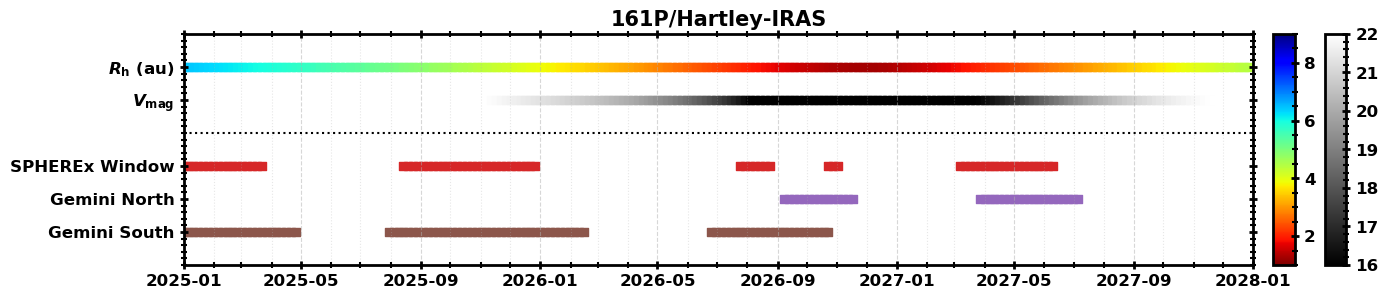

In [48]:
mask_sx = (eph.elong > 80) & (eph.elong < 110)

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot()

date_list = pd.to_datetime(df_visible.datetime_jd, unit="D", origin="julian")

sc_r  = ax.scatter(date_list, [1]*len(date_list), c=eph.r, cmap="jet_r", marker="s", vmin=1, vmax=9)
sc_v  = ax.scatter(date_list, [2]*len(date_list), c=eph.Tmag, cmap="gray", marker="s", vmin=16, vmax=22)
ax.axhline(y=3, color="k", linestyle=":")
sc_sx = ax.scatter(date_list[mask_sx], [4]*sum(mask_sx), c="C3", marker="s")
observatories = {
    "gemini_north": {"yloc": 5, "color": "C4"},
    "gemini_south": {"yloc": 6, "color": "C5"},
}
for observatory, props in observatories.items():
    mask_visible = df_visible[f"is_visible_{observatory}"]
    ax.scatter(date_list[mask_visible], [props["yloc"]]*sum(mask_visible), 
               c=props["color"], marker="s")

yticks = [1, 2, 4, 5, 6]
yticklabels = [
    r"$R_\mathrm{h}$ (au)",
    r"$V_\mathrm{mag}$",
    "SPHEREx Window",
    "Gemini North",
    "Gemini South"
]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_title(f"{eph['targetname'].iloc[0]}")

# Colorbars
divider = make_axes_locatable(ax)
cax_r = divider.append_axes("right", size="2%", pad=0.2)
cax_v = divider.append_axes("right", size="2%", pad=0.3)
cb_r = plt.colorbar(sc_r, cax=cax_r, orientation="vertical")
# cb_r.set_label(r"$R_\mathrm{h}$ [au]")
cb_v = plt.colorbar(sc_v, cax=cax_v, orientation="vertical")
# cb_v.set_label(r"$V_\mathrm{mag}$")

ax.set_xlim(date_list.min(), date_list.max()+pd.Timedelta(days=5))
ax.set_ylim(7, 0)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True, axis="x", which="major", linestyle="--", alpha=0.5)
ax.grid(True, axis="x", which="minor", linestyle=":", alpha=0.3)

plt.show()